<a href="https://colab.research.google.com/github/youssefdarwish37/modulation-Classification/blob/main/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
no from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


to do 


1.   enter more than one channel
expected 2 best is raw + integral 

2.   lstm - vanilla rnn 

3.   big picture 

4.   pdf latex form









#IMPORTS

In [ ]:
import os
import math
import glob
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchsummary import summary
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from numpy import savetxt
import torch.cuda
from sklearn.metrics import confusion_matrix
import seaborn as sn
torch.cuda.init()
cuda = torch.device('cuda')

# GLOBALS

In [ ]:
#initializing all arrays used
tracks = []
X = []  
lbl = []

# 1 - DOWNLOAD THE DATA SET

In [ ]:
filename = "/content/drive/MyDrive/RML2016.10b/RML2016.10b.dat"
open_file = open(filename,'rb')
Xd = cPickle.load(open_file, encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
print(np.array(X).shape)
print(np.array(lbl).shape)

(1200000, 2, 128)
(1200000, 2)


# 2 - CREATE FEATURE SPACE

In [ ]:
####Raw time series
####First derivative in time
derivatives = [normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))]
####Integral in time
integrals = [normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))]

In [ ]:
Y = []
for i in (lbl):
  lbl0 = i[0]
  lbl1 = i[1]
  if lbl0 == '8PSK':
    Y.append([0,lbl1])

  elif lbl0 == 'BPSK':
    Y.append([1,lbl1])

  elif lbl0 == 'PAM4':
    Y.append([2,lbl1])

  elif lbl0 =='QPSK':
    Y.append([3,lbl1])

  elif lbl0 == 'AM-DSB':
    Y.append([4,lbl1])

  elif lbl0 == 'CPFSK':
    Y.append([5,lbl1])

  elif lbl0 == 'QAM16':

    Y.append([6,lbl1])
  elif lbl0 == 'WBFM':

    Y.append([7,lbl1])
  elif lbl0 == 'AM-SSB':

    Y.append([8,lbl1])
  elif lbl0 == 'GFSK':

    Y.append([9,lbl1])
  elif lbl0 == 'QAM64':

    Y.append([10,lbl1])

Y = np.array(Y)

In [ ]:

print(Y)


[[  0 -20]
 [  0 -20]
 [  0 -20]
 ...
 [  7  18]
 [  7  18]
 [  7  18]]


# 3 - BUILDING MODEL

In [ ]:
## using built in function train_test_split
def split(featureSpace,labels, testsize = 0.3):
     return train_test_split(featureSpace,labels,test_size=testsize, random_state = 42, stratify = labels)


In [ ]:
## first class for reflecting dataset  
class myDataset(Dataset):
  def __init__(self, array, label):
    self.array = array
    self.label = label

  def __getitem__(self, index):
    #takes index and return trainig example and its label

    return torch.tensor(self.array[index], dtype=torch.float),torch.tensor(self.label[index],dtype=torch.int)
  def __len__(self):
    #returns number of examples
    return len(self.array)
  

In [ ]:
print(np.array(X).shape)
print(np.array(derivatives).shape)
print(np.array(integrals).shape)
derivatives=np.reshape(derivatives,(np.array(derivatives).shape[1],np.array(derivatives).shape[0],np.array(derivatives).shape[2]))
integrals=np.reshape(integrals,(np.array(integrals).shape[1],np.array(integrals).shape[0],np.array(integrals).shape[2]))

print(np.array(X).shape)
print(np.array(derivatives).shape)
print(np.array(integrals).shape)


(1200000, 2, 128)
(2, 1200000, 128)
(2, 1200000, 128)
(1200000, 2, 128)
(1200000, 2, 128)
(1200000, 2, 128)


In [ ]:
def run_model(model, train_dataloader,validation_dataloader, optimizer,train = True):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  # print(f"Using {device}")
  if train:
    model.train()
  pred_training = []
  labels_training = []
  loss = nn.CrossEntropyLoss()
  total_loss_training = 0
  for (data, label) in (train_dataloader):

    label = label.type(torch.LongTensor) # <-(casting)
    ## get the inputs; data is a list of [inputs, labels]
    data, label = data.cuda(), label.cuda()
    ## zero the parameter gradients
    optimizer.zero_grad() 
    output = model(data)
    loss_ = loss(output, label)
    total_loss_training += loss_.item()
    loss_.backward()
    optimizer.step()
    pred_training += output.tolist()
    labels_training += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()

  model.eval()
  total_loss_validation = 0
  pred_validation = []
  labels_validation = []
  for data , label in validation_dataloader:
    label = label.type(torch.LongTensor)
    data, label = data.cuda(), label.cuda()
    torch.cuda.empty_cache()
    output = model(data)
    torch.cuda.empty_cache()
    loss_ = loss(output, label)
    total_loss_validation += loss_.item()
    pred_validation += output.tolist()
    labels_validation += label.tolist()
    label = label.cpu()
    data = data.cpu()
    torch.cuda.empty_cache()

  return labels_training, pred_training, total_loss_training/len(train_dataloader),labels_validation,pred_validation,total_loss_validation/len(validation_dataloader)



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def test_model(model, test_dataloader, train = False):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  
  # print(f"Using {device}")
  # turn off autograd for testing evaluation

  
  # set the model in evaluation mode
  model.eval()
  loss = nn.CrossEntropyLoss()

  
  # initialize a list to store our predictions
  preds = []
  total_loss_test = 0
  # loop over the test set
  for (x, y) in test_dataloader:
    y = y.type(torch.LongTensor)
    x, y = x.cuda(), y.cuda()
    # make the predictions and add them to the list
    output = model(x)
    preds.extend(output.argmax(axis=1).cpu().numpy())
    loss_ = loss(output, y)
    total_loss_test += loss_.item()

    torch.cuda.empty_cache()
  return preds, total_loss_test/len(test_dataloader)

##cnn model

In [ ]:
## splitting the data into 70% tarining ,30% testing and 5% of the testing for validation
data_train, data_test, label_train, label_test = split(np.array(X),Y)
data_train,data_val,label_train,label_val= split(data_train,label_train,0.05)
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)


# reshaping the input data to be suitable for convloution 
data_train=np.reshape(data_train,(np.array(data_train).shape[0],1,np.array(data_train).shape[2],np.array(data_train).shape[1]))
data_test=np.reshape(data_test,(np.array(data_test).shape[0],1,np.array(data_test).shape[2],np.array(data_test).shape[1]))
data_val=np.reshape(data_val,(np.array(data_val).shape[0],1,np.array(data_val).shape[2],np.array(data_val).shape[1]))
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)

(798000, 2, 128)
(360000, 2, 128)
(42000, 2, 128)
(798000, 1, 128, 2)
(360000, 1, 128, 2)
(42000, 1, 128, 2)


In [ ]:
batch_size = 128
customDataset = myDataset(data_train,label_train[:,0])
train1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True)

customDataset = myDataset(data_test,label_test[:,0])
test1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False)

customDataset = myDataset(data_val,label_val[:,0])
validation1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False)

In [ ]:
## In a CNN, the input is a tensor(a tensor is an algebraic object that describes a multilinear relationship between sets of algebraic objects) 
## with a shape: (number of inputs) x (input height) x (input width) x (input channels)
## Pooling layers reduce the dimensions of data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Local pooling combines small clusters
## Fully connected layers connect every neuron in one layer to every neuron in another layer. It is the same as a traditional multilayer perceptron neural network (MLP). The flattened matrix goes through a fully connected layer to classify the images.
## dropout hiding some of the data to increase learning
##
class Model(nn.Module):
  ## main architecture class
  def __init__(self):
    ## constructor:ba3rf el layers el 3aizha hena
    super().__init__()
        ## 2 conv blocks / dropout / flatten / linear / softmax
    self.conv1 = nn.Sequential(
        nn.Conv2d(1,64,(3,1),1,0),
        nn.BatchNorm2d(64).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=1)
        
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64,16,(3,2),1,0),
        nn.BatchNorm2d(16).to(cuda),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=1)
    )
   
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(1984, 128)
    self.linear2 = nn.Linear(128, 11)
    self.softmax = nn.Softmax(dim=1)
    self.dropout1 = nn.Dropout(0.5).to(cuda)
    


  def forward(self, input_data):
      x = self.conv1(input_data)
      x = self.dropout1(x).to(cuda)
      x = self.conv2(x)
      

      

      x = self.dropout1(x).to(cuda)
      x = self.flatten(x)
      x = self.linear1(x)
      x=F.relu(x)
      x = self.linear2(x)
      predictions = self.softmax(x) ## probabilty for classes
      return predictions

In [ ]:
model = Model()

train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
#epoch-->repitions on all data
#lr-->learnable rate 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 2)

for e in range(25):
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation  = run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  # labels_training, pred_training, loss_training= run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())

  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))
  scheduler.step(loss_validation)
  
  print("\nepoch =",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")





epoch = 1 

**************************************
training accuarcy: 0.33446491228070174
validation accuarcy: 0.37792857142857145
training f1_score: 0.3080180509874029
validation f1_score: 0.33994747032081235
training loss: 2.198279791941333
validation loss: 2.1532492688361633
**************************************

epoch = 2 

**************************************
training accuarcy: 0.3748947368421053
validation accuarcy: 0.4022142857142857
training f1_score: 0.3537356516823032
validation f1_score: 0.37513291070264143
training loss: 2.1568527200648377
validation loss: 2.132220662473545
**************************************

epoch = 3 

**************************************
training accuarcy: 0.39157769423558897
validation accuarcy: 0.4126666666666667
training f1_score: 0.36805346599823596
validation f1_score: 0.38434603492697245
training loss: 2.1404166815848757
validation loss: 2.1199418846234725
**************************************

epoch = 4 

*******************************

In [ ]:
savetxt('/content/drive/MyDrive/train_acc_cnn.csv', train_acc, delimiter=',')
savetxt('/content/drive/MyDrive/val_acc_cnn.csv', val_acc, delimiter=',')
savetxt('/content/drive/MyDrive/train_loss_cnn.csv', train_loss, delimiter=',')
savetxt('/content/drive/MyDrive/validation_loss_cnn.csv', validation_loss, delimiter=',')


In [ ]:
from torchvision import models
print((data_train[0]).shape)
from torchsummary import summary
summary(model, np.array(data_train[0]).shape,batch_size)

(1, 128, 2)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 126, 2]             256
       BatchNorm2d-2          [128, 64, 126, 2]             128
              ReLU-3          [128, 64, 126, 2]               0
         MaxPool2d-4          [128, 64, 126, 2]               0
           Dropout-5          [128, 64, 126, 2]               0
            Conv2d-6          [128, 16, 124, 1]           6,160
       BatchNorm2d-7          [128, 16, 124, 1]              32
              ReLU-8          [128, 16, 124, 1]               0
         MaxPool2d-9          [128, 16, 124, 1]               0
          Dropout-10          [128, 16, 124, 1]               0
          Flatten-11                [128, 1984]               0
           Linear-12                 [128, 128]         254,080
           Linear-13                  [128, 11]           1,419
          Softmax-14       

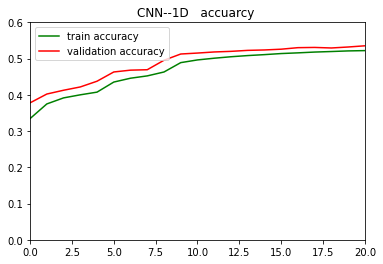

In [ ]:
from google.colab import files


fig, ax = plt.subplots()
plt.ylim(0,0.6)
plt.xlim(0,20)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D   accuarcy ')
plt.show()


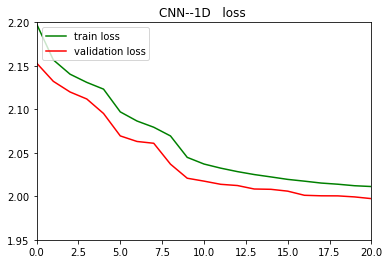

In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(1.95,2.2)
plt.xlim(0,20)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D   loss ')
plt.show()


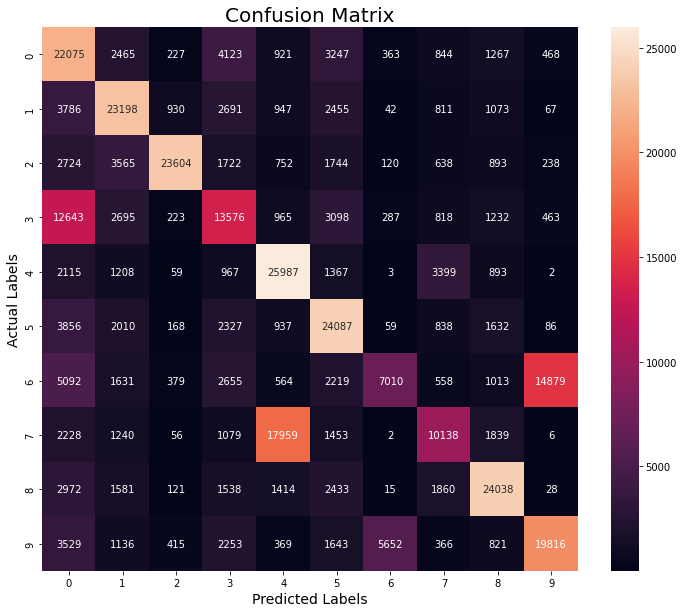

f1 score:  0.5288888081595499
test accuarcy: 0.5375805555555555


In [ ]:

pred,loss=test_model(model,test1_dataloader)
cm = confusion_matrix(label_test[:,0],pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print('f1 score: ', f1_score(label_test[:,0],pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label_test[:,0],pred))

## rnn



In [ ]:
## splitting the data into 70% tarining ,30% testing and 5% of the testing for validation
data_train, data_test, label_train, label_test = split(np.array(X),Y)
data_train,data_val,label_train,label_val= split(data_train,label_train,0.05)
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)


# reshaping the input data to be suitable for convloution 
data_train=np.reshape(data_train,(np.array(data_train).shape[0],1,np.array(data_train).shape[2],np.array(data_train).shape[1]))
data_test=np.reshape(data_test,(np.array(data_test).shape[0],1,np.array(data_test).shape[2],np.array(data_test).shape[1]))
data_val=np.reshape(data_val,(np.array(data_val).shape[0],1,np.array(data_val).shape[2],np.array(data_val).shape[1]))
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)

(798000, 2, 128)
(360000, 2, 128)
(42000, 2, 128)
(798000, 1, 128, 2)
(360000, 1, 128, 2)
(42000, 1, 128, 2)


In [ ]:
batch_size = 128
customDataset = myDataset(data_train,label_train[:,0])
train1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True, num_workers = 0)

customDataset = myDataset(data_test,label_test[:,0])
test1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

customDataset = myDataset(data_val,label_val[:,0])
validation1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

In [ ]:
class RNN(nn.Module):
    def __init__(self):
      super(RNN, self).__init__()
      self.rnn = nn.RNN(256, 512, 4)
      self.fc = nn.Linear(512, 11)

    def forward(self, input_data):
      h0 = torch.zeros(4, 1, 512).to(cuda)
      batchSize = input_data.size(0)
      x = input_data.reshape((batchSize,1,256))
      x, _ = self.rnn(x,  h0)
      x = torch.flatten(x,1).to(cuda)
      x = x.contiguous().view(-1, 512)
      x = self.fc(x).to(cuda)
      output = F.log_softmax(x, dim=1).to(cuda)
      return output
torch.cuda.init()
cuda = torch.device('cuda')



In [ ]:
model = RNN()

train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
#epoch-->repitions on all data
#lr-->learnable rate 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 2)

for e in range(50):
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation  = run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  # labels_training, pred_training, loss_training= run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())

  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))
  scheduler.step(loss_validation)
  print("\nepoch =",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")




epoch = 1 

**************************************
training accuarcy: 0.16538847117794486
validation accuarcy: 0.1662142857142857
training f1_score: 0.1649073957429202
validation f1_score: 0.13302506732279143
training loss: 2.1203547288631572
validation loss: 2.1070699655538636
**************************************

epoch = 2 

**************************************
training accuarcy: 0.17476942355889724
validation accuarcy: 0.18854761904761905
training f1_score: 0.1720354806865828
validation f1_score: 0.15406322623915072
training loss: 2.094847090643888
validation loss: 2.0661574863010626
**************************************

epoch = 3 

**************************************
training accuarcy: 0.19452882205513786
validation accuarcy: 0.19547619047619047
training f1_score: 0.18418697108051676
validation f1_score: 0.16738293790567862
training loss: 2.0576535875738
validation loss: 2.057941368647984
**************************************

epoch = 4 

********************************

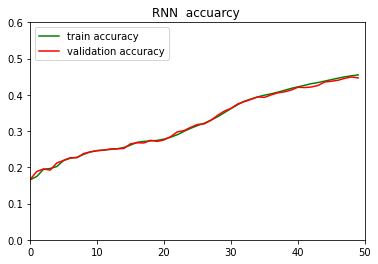

In [ ]:
from google.colab import files


fig, ax = plt.subplots()
plt.ylim(0,0.6)
plt.xlim(0,50)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='RNN  accuarcy ')
plt.show()


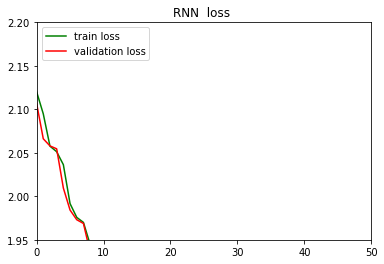

In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(1.95,2.2)
plt.xlim(0,50)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='RNN  loss ')
plt.show()


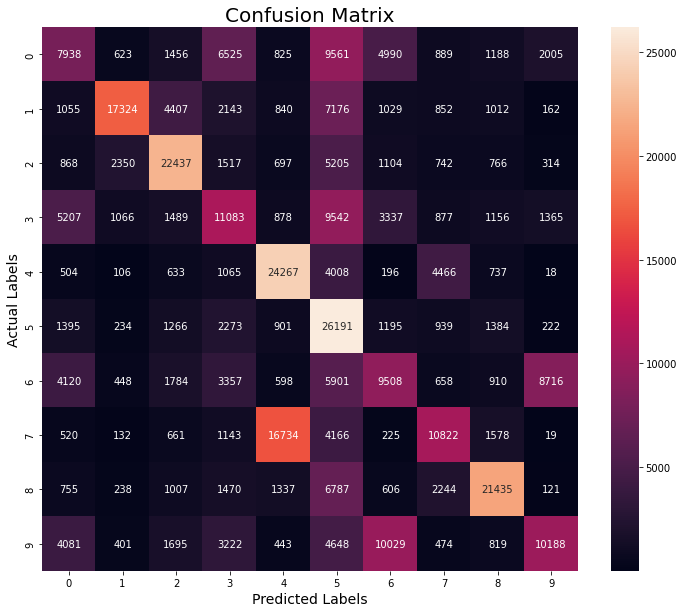

f1 score:  0.4426983571014395
test accuarcy: 0.4477583333333333


In [ ]:

pred,loss=test_model(model,test1_dataloader)
cm = confusion_matrix(label_test[:,0],pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print('f1 score: ', f1_score(label_test[:,0],pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label_test[:,0],pred))

In [ ]:
savetxt('/content/drive/MyDrive/train_acc_rnn.csv', train_acc, delimiter=',')
savetxt('/content/drive/MyDrive/val_acc_rnn.csv', val_acc, delimiter=',')
savetxt('/content/drive/MyDrive/train_loss_rnn.csv', train_loss, delimiter=',')
savetxt('/content/drive/MyDrive/validation_loss_rnn.csv', validation_loss, delimiter=',')


## lstm

In [ ]:
## splitting the data into 70% tarining ,30% testing and 5% of the testing for validation
data_train, data_test, label_train, label_test = split(np.array(X),Y)
data_train,data_val,label_train,label_val= split(data_train,label_train,0.05)
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)

# reshaping the input data to be suitable for convloution 
data_train=np.reshape(data_train,(np.array(data_train).shape[0],1,np.array(data_train).shape[2]*np.array(data_train).shape[1]))
data_test=np.reshape(data_test,(np.array(data_test).shape[0],1,np.array(data_test).shape[2]*np.array(data_test).shape[1]))
data_val=np.reshape(data_val,(np.array(data_val).shape[0],1,np.array(data_val).shape[2]*np.array(data_val).shape[1]))
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)

(798000, 2, 128)
(360000, 2, 128)
(42000, 2, 128)
(798000, 1, 256)
(360000, 1, 256)
(42000, 1, 256)


In [ ]:
batch_size = 128
customDataset = myDataset(data_train,label_train[:,0])
train1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True, num_workers = 0)

customDataset = myDataset(data_test,label_test[:,0])
test1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

customDataset = myDataset(data_val,label_val[:,0])
validation1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.num_layers = 4
        self.hidden_size = 128

        self.lstm = nn.LSTM(256, self.hidden_size, self.num_layers, batch_first=True).to(cuda)
        self.fc = nn.Linear(self.hidden_size, 11).to(cuda)
        
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)

        out, _ = self.lstm(x, (h0,c0))  
        out = out.contiguous().view(-1, 128)
        out = self.fc(out)
        return out


In [ ]:
model = LSTM()

train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
#epoch-->repitions on all data
#lr-->learnable rate 
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 2)

for e in range(50):
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation  = run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  # labels_training, pred_training, loss_training= run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())

  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))
  scheduler.step(loss_validation)
  print("\nepoch =",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")


epoch = 1 

**************************************
training accuarcy: 0.2942406015037594
validation accuarcy: 0.3600952380952381
training f1_score: 0.29167372727096896
validation f1_score: 0.32882862794943324
training loss: 1.7405729819797189
validation loss: 1.5207194336279548
**************************************

epoch = 2 

**************************************
training accuarcy: 0.3993045112781955
validation accuarcy: 0.4190238095238095
training f1_score: 0.38720723804596235
validation f1_score: 0.41206770264142445
training loss: 1.446750784685063
validation loss: 1.393322934495642
**************************************

epoch = 3 

**************************************
training accuarcy: 0.4318421052631579
validation accuarcy: 0.42854761904761907
training f1_score: 0.4188734987411358
validation f1_score: 0.3837629448491286
training loss: 1.360779601531499
validation loss: 1.332939236722094
**************************************

epoch = 4 

***********************************

In [ ]:
from google.colab import files

fig, ax = plt.subplots()
plt.ylim(0,0.6)
plt.xlim(0,50)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='LSTM  accuarcy ')
plt.show()


In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(0.9,1.6)
plt.xlim(0,50)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='LSTM  loss ')
plt.show()


In [ ]:
pred,loss=test_model(model,test1_dataloader)
cm = confusion_matrix(label_test[:,0],pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print('f1 score: ', f1_score(label_test[:,0],pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label_test[:,0],pred))

In [ ]:
savetxt('/content/drive/MyDrive/train_acc_lstm.csv', train_acc, delimiter=',')
savetxt('/content/drive/MyDrive/val_acc_lstm.csv', val_acc, delimiter=',')
savetxt('/content/drive/MyDrive/train_loss_lsym.csv', train_loss, delimiter=',')
savetxt('/content/drive/MyDrive/validation_loss_lstm.csv', validation_loss, delimiter=',')

## BONUS CONV-LSTM

In [ ]:
## splitting the data into 70% tarining ,30% testing and 5% of the testing for validation
data_train, data_test, label_train, label_test = split(np.array(X),Y)
data_train,data_val,label_train,label_val= split(data_train,label_train,0.05)
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)


# reshaping the input data to be suitable for convloution 
data_train=np.reshape(data_train,(np.array(data_train).shape[0],1,np.array(data_train).shape[2]*np.array(data_train).shape[1]))
data_test=np.reshape(data_test,(np.array(data_test).shape[0],1,np.array(data_test).shape[2]*np.array(data_test).shape[1]))
data_val=np.reshape(data_val,(np.array(data_val).shape[0],1,np.array(data_val).shape[2]*np.array(data_val).shape[1]))
print(np.array(data_train).shape)
print(np.array(data_test).shape)
print(np.array(data_val).shape)

(798000, 2, 128)
(360000, 2, 128)
(42000, 2, 128)
(798000, 1, 256)
(360000, 1, 256)
(42000, 1, 256)


In [ ]:
batch_size = 256
customDataset = myDataset(data_train,label_train[:,0])
train1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = True, num_workers = 0)

customDataset = myDataset(data_test,label_test[:,0])
test1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

customDataset = myDataset(data_val,label_val[:,0])
validation1_dataloader = DataLoader(customDataset,batch_size = batch_size, shuffle = False, num_workers = 0)

In [ ]:
class CONVV_LSTM(nn.Module):
    def __init__(self):
        super(CONVV_LSTM, self).__init__()
        self.num_layers = 4
        self.hidden_size = 128


        self.cnn1 = nn.Conv1d(1, 16, 3, stride=1, padding=1).to(cuda)

        self.cnn2 = nn.Conv1d(16, 64, 3, stride=1, padding=1).to(cuda)

        self.cnn3 = nn.Conv1d(64, 256, 3, stride=2, padding=1).to(cuda)

        self.pool = nn.MaxPool1d(2, 2).to(cuda)

        self.flatten = nn.Flatten()

        self.lstm = nn.LSTM(256, self.hidden_size, self.num_layers, batch_first=True).to(cuda)

        self.fc = nn.Linear(self.hidden_size, 11).to(cuda)

    def forward(self, input):
      x = self.cnn1(input)
      x = self.cnn2(x)
      x = self.cnn3(x)
      x = self.flatten(x)

      x = x.reshape((input.size(0), 1, 256)) 

      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)

      out, _ = self.lstm(x, (h0,c0))  
      out = out.contiguous().view(-1, 128)
      out = self.fc(out)

      return out

In [ ]:
model = CONVV_LSTM()

train_acc = []
val_acc = []
train_loss = []
validation_loss=[]
#epoch-->repitions on all data
#lr-->learnable rate 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience  = 2)

for e in range(5):
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  labels_training, pred_training, loss_training,labels_validation, pred_validation, loss_validation  = run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  # labels_training, pred_training, loss_training= run_model(model, train1_dataloader,validation1_dataloader,optimizer)
  
  pred=[]
  for i in pred_training:
      pred.append((np.array(i)).argmax())
  pred2=[]
  for i in pred_validation:
      pred2.append((np.array(i)).argmax())

  train_acc.append(accuracy_score(labels_training,pred))
  val_acc.append(accuracy_score(labels_validation,pred2))
  train_loss.append((loss_training))
  validation_loss.append((loss_validation))
  scheduler.step(loss_validation)
  print("\nepoch =",e+1,"\n")
  print("**************************************")
  print("training accuarcy:",accuracy_score(labels_training,pred))
  print("validation accuarcy:",accuracy_score(labels_validation,pred2))
  print("training f1_score:",f1_score(labels_training,pred,average = 'weighted'))
  print("validation f1_score:",f1_score(labels_validation,pred2,average = 'weighted'))
  print("training loss:",loss_training)
  print("validation loss:",loss_validation)
  print("**************************************")




RuntimeError: ignored

In [ ]:
from google.colab import files


fig, ax = plt.subplots()
plt.ylim(0,0.6)
plt.xlim(0,50)
ax.plot(train_acc, color = 'green', label = 'train accuracy')
ax.plot(val_acc, color = 'red', label = 'validation accuracy')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D   accuarcy ')
plt.show()


In [ ]:
from google.colab import files
fig, ax = plt.subplots()
plt.ylim(1.95,2.2)
plt.xlim(0,50)
ax.plot(train_loss, color = 'green', label = 'train loss')
ax.plot(validation_loss, color = 'red', label = 'validation loss')
ax.legend(loc = 'upper left')
ax.set(title='CNN--1D   loss ')
plt.show()


In [ ]:

pred,loss=test_model(model,test1_dataloader)
cm = confusion_matrix(label_test[:,0],pred)
plt.figure(figsize = (12, 10))
sn.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print('f1 score: ', f1_score(label_test[:,0],pred,average = 'weighted'))
print("test accuarcy:",accuracy_score(label_test[:,0],pred))

#4 - BIG PICTURE

In [ ]:
from numpy import loadtxt

train_acc_cnn = loadtxt('/content/drive/MyDrive/train_acc_cnn.csv', delimiter=',')
val_acc_cnn = loadtxt('/content/drive/MyDrive/val_acc_cnn.csv', delimiter=',')
train_loss_cnn = loadtxt('/content/drive/MyDrive/train_loss_cnn.csv', delimiter=',')
validation_loss_cnn = loadtxt('/content/drive/MyDrive/validation_loss_cnn.csv', delimiter=',')

train_acc_rnn = loadtxt('/content/drive/MyDrive/train_acc_rnn.csv', delimiter=',')
val_acc_rnn = loadtxt('/content/drive/MyDrive/val_acc_rnn.csv', delimiter=',')
train_loss_rnn = loadtxt('/content/drive/MyDrive/train_loss_rnn.csv', delimiter=',')
validation_loss_rnn = loadtxt('/content/drive/MyDrive/validation_loss_rnn.csv', delimiter=',')

train_acc_lstm = loadtxt('/content/drive/MyDrive/train_acc_lstm.csv', delimiter=',')
val_acc_lstm= loadtxt('/content/drive/MyDrive/val_acc_lstm.csv', delimiter=',')
train_loss_lstm = loadtxt('/content/drive/MyDrive/train_loss_lstm.csv', delimiter=',')
validation_loss_lstm = loadtxt('/content/drive/MyDrive/validation_loss_lstm.csv', delimiter=',')


In [ ]:
model = Model()

In [ ]:
a=label_test[:,1]
b=label_test

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
SNRs = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18]

def test_model(model, train = False):
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()

  
  # set the model in evaluation mode
  model.eval()
  loss = nn.CrossEntropyLoss()

  
  # initialize a list to store our predictions
  true=[]
  pred = []
  snr_accuarcy = []
  # loop over the test set

  test_list = np.array(list(map(int,a)))

  for snr in SNRs:
      test_X_i = data_test[np.where(test_list == snr)]
      test_Y_i = label_test[np.where(test_list  == snr)] 
      test_Y_i = np.array(list(map(int, test_Y_i[:,0])))
      test_dataset = myDataset(test_X_i,test_Y_i)
      test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = False)
      for (x, y) in test_dataloader:
        y = y.type(torch.LongTensor)
        x, y = x.cuda(), y.cuda()
        # make the predictions and add them to the list
        output = model(x)
        pred.extend(output.argmax(axis=1).cpu().numpy())
        y = y.data.cpu().numpy()
        true.extend(y) # Save Truth
        torch.cuda.empty_cache()
      cm = confusion_matrix(true,pred)
      plt.figure(figsize = (12, 10))
      ax = sn.heatmap(cm, annot=True, fmt="d", cmap = 'rocket_r', 
                        xticklabels = ['8PSK','BPSK','PAM4','QPSK','AM-DSB','CPFSK','QAM16','WBFM','GFSK','QAM64'], 
                        yticklabels = ['8PSK','BPSK','PAM4','QPSK','AM-DSB','CPFSK','QAM16','WBFM','GFSK','QAM64'])
      plt.title(f'Confusion Matrix at SNR = {snr}', size=20)
      plt.xlabel('Predicted Labels', size=14)
      plt.ylabel('Actual Labels', size=14)
      plt.show()
      print('f1 score: ', f1_score(true,pred,average = 'weighted'))
      snr_accuarcy.append(accuracy_score(true,pred))
      print("test accuarcy:",accuracy_score(true,pred))
  return snr_accuarcy

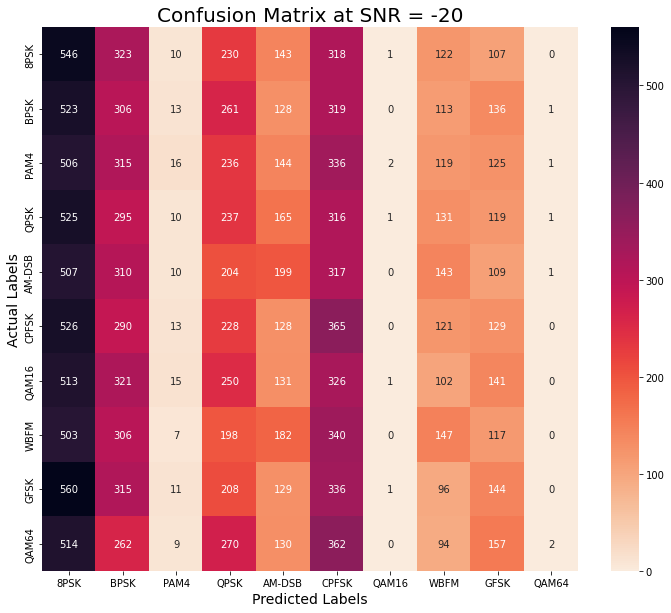

f1 score:  0.08722098485362192
test accuarcy: 0.10905555555555556


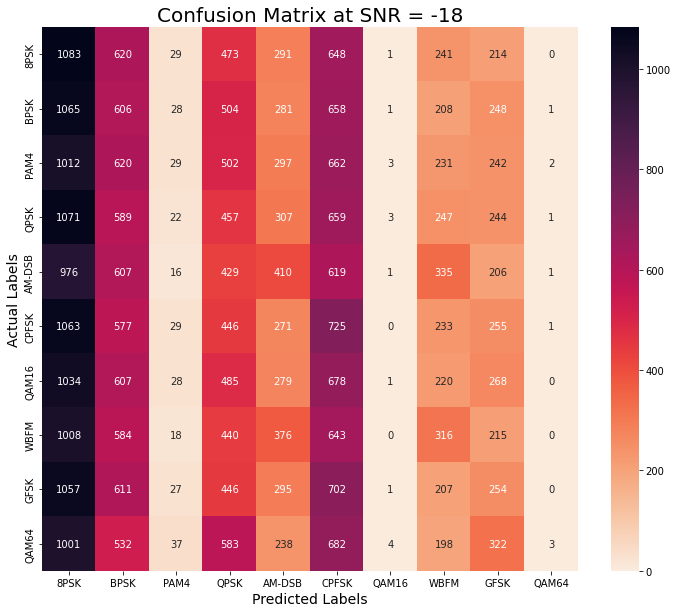

f1 score:  0.08613419692534033
test accuarcy: 0.1078888888888889


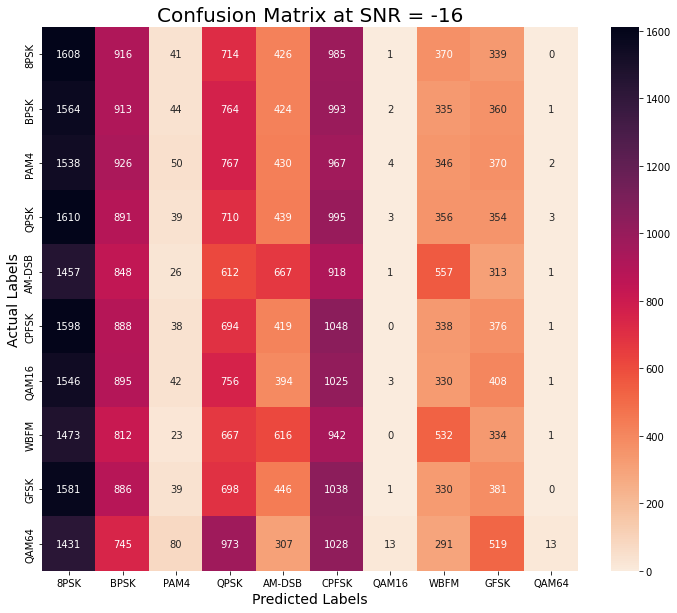

f1 score:  0.08878525496024518
test accuarcy: 0.10972222222222222


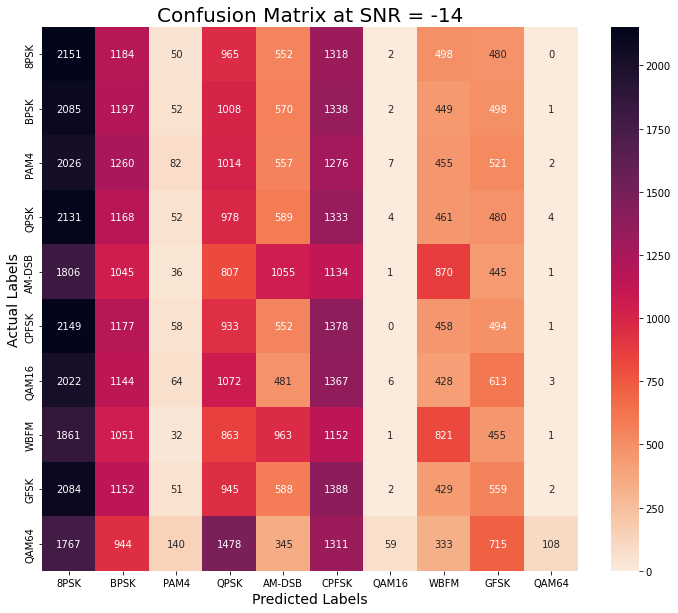

f1 score:  0.09678160215293366
test accuarcy: 0.11576388888888889


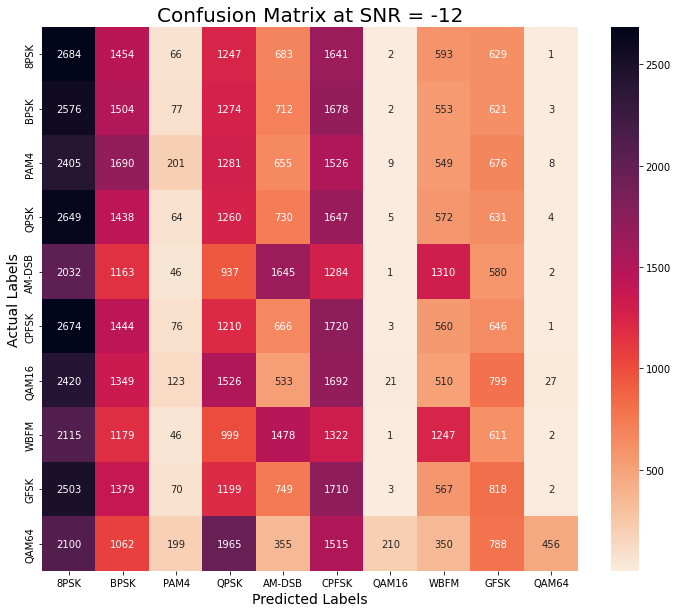

f1 score:  0.11420850239689112
test accuarcy: 0.1284


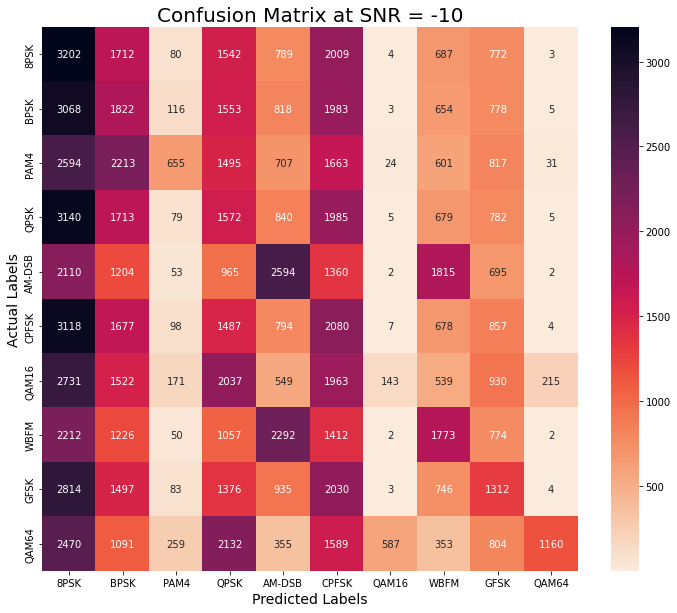

f1 score:  0.1450498024798795
test accuarcy: 0.1510462962962963


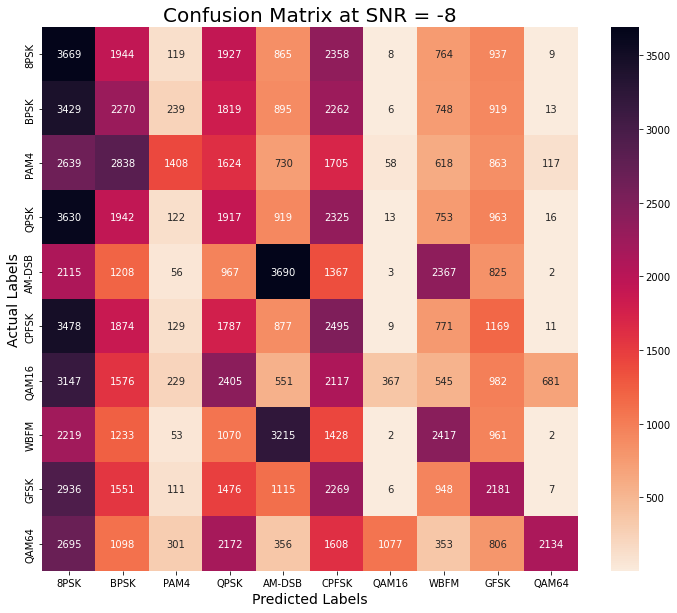

f1 score:  0.17992460590829756
test accuarcy: 0.17895238095238095


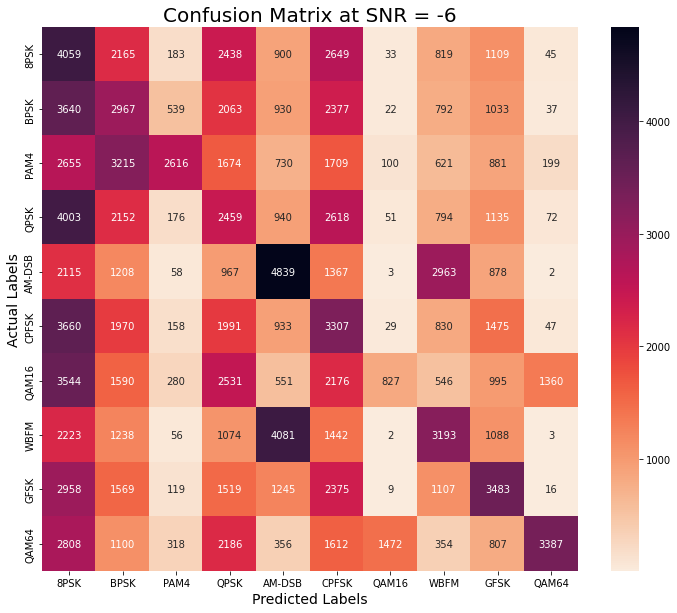

f1 score:  0.2225421815256602
test accuarcy: 0.21622916666666667


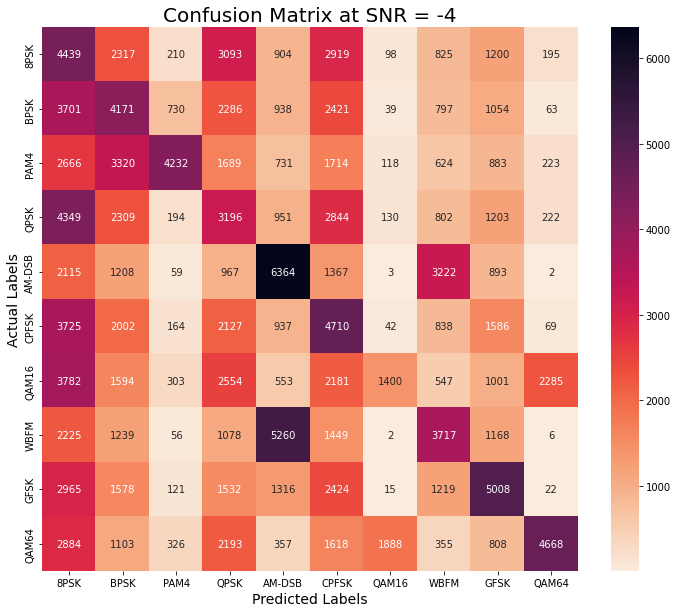

f1 score:  0.26674731249969
test accuarcy: 0.2586728395061728


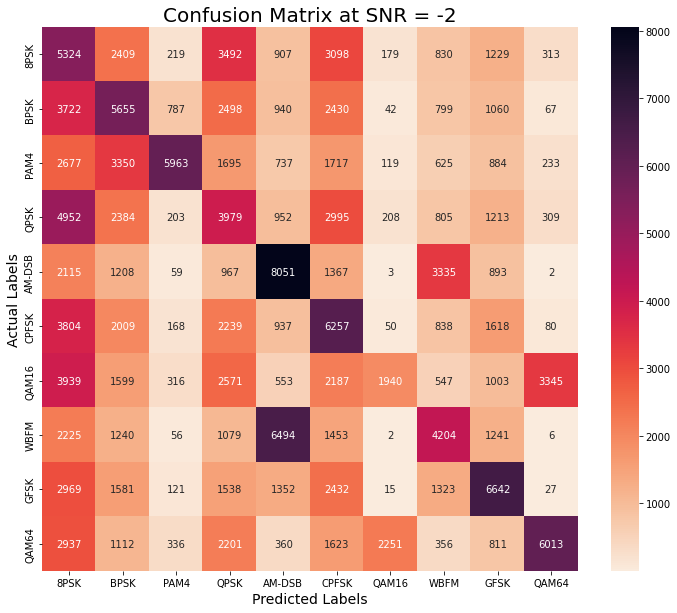

f1 score:  0.3073869614816358
test accuarcy: 0.30015555555555556


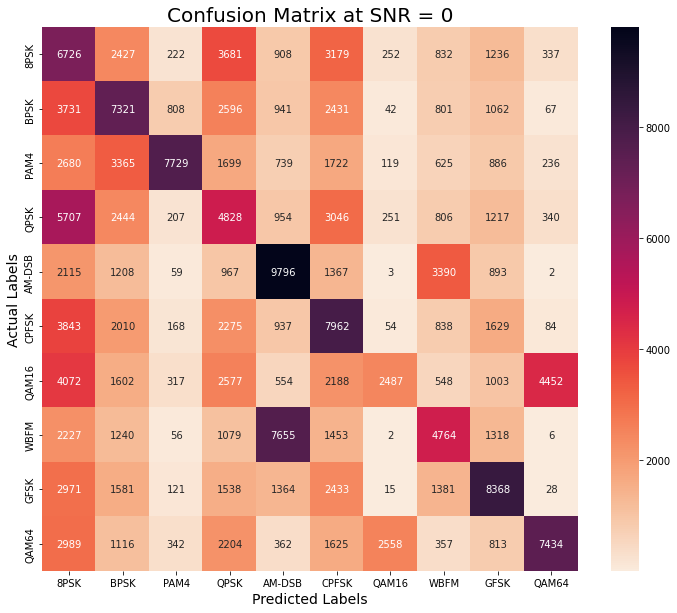

f1 score:  0.345731349924396
test accuarcy: 0.340479797979798


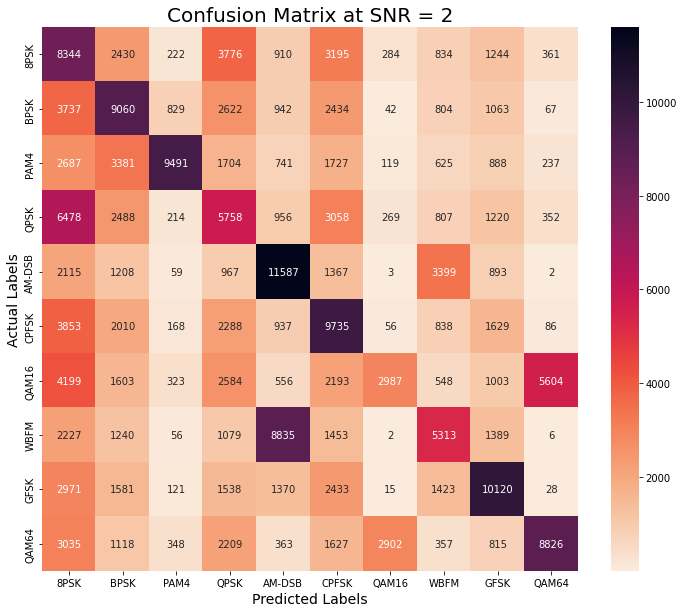

f1 score:  0.37880469655582155
test accuarcy: 0.37602314814814813


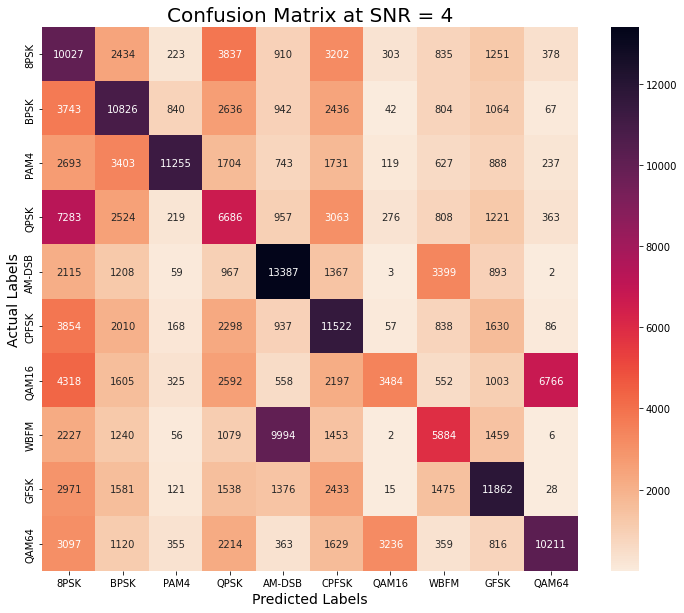

f1 score:  0.40713795733951
test accuarcy: 0.4065982905982906


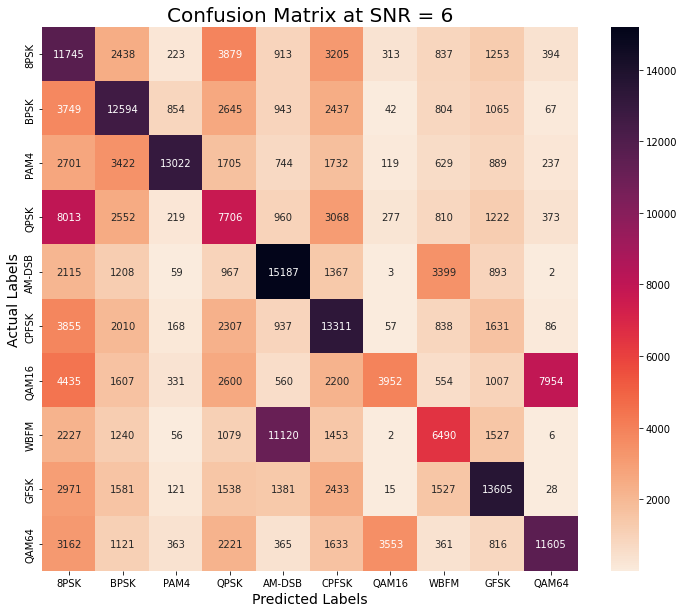

f1 score:  0.43190553280121663
test accuarcy: 0.43340079365079365


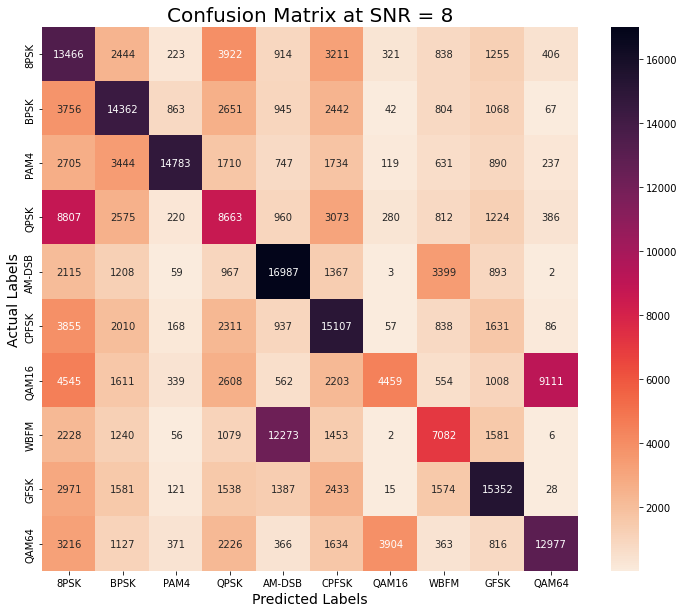

f1 score:  0.4532620472425983
test accuarcy: 0.45643703703703703


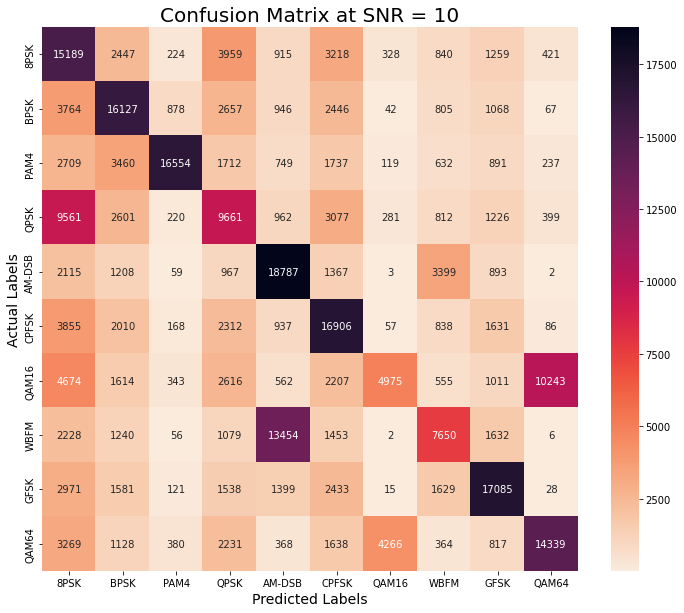

f1 score:  0.4720118410565976
test accuarcy: 0.47664236111111113


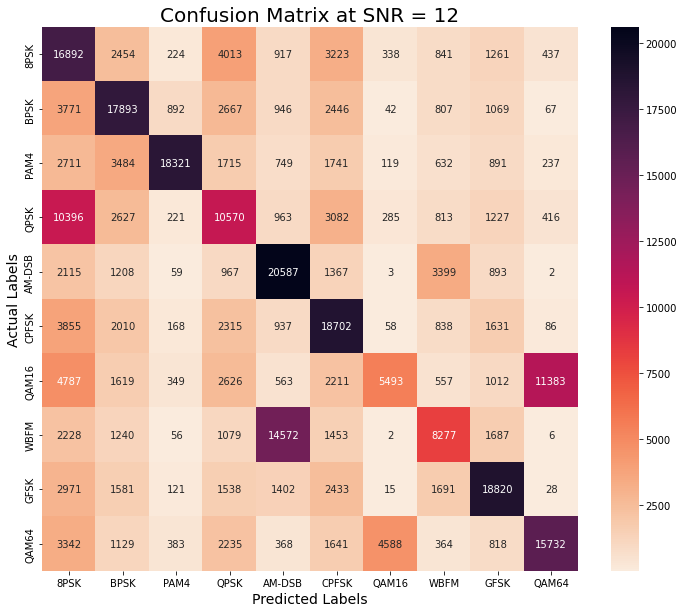

f1 score:  0.48858247665362214
test accuarcy: 0.4944019607843137


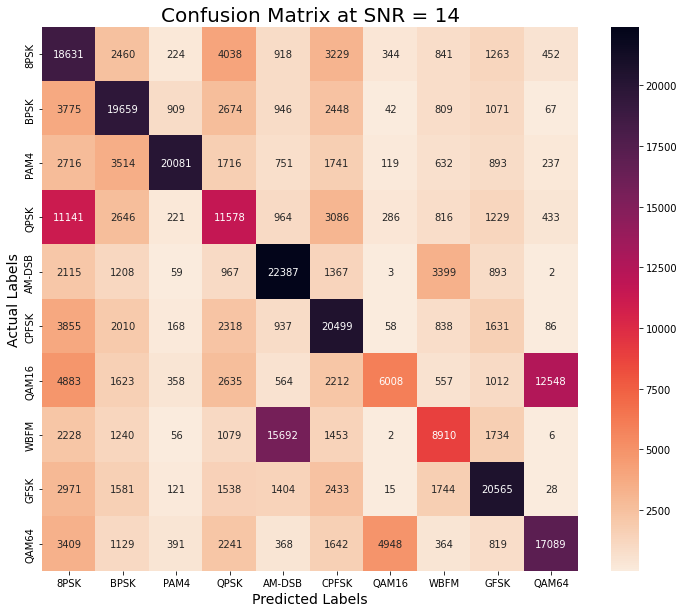

f1 score:  0.5036217409022877
test accuarcy: 0.5105154320987655


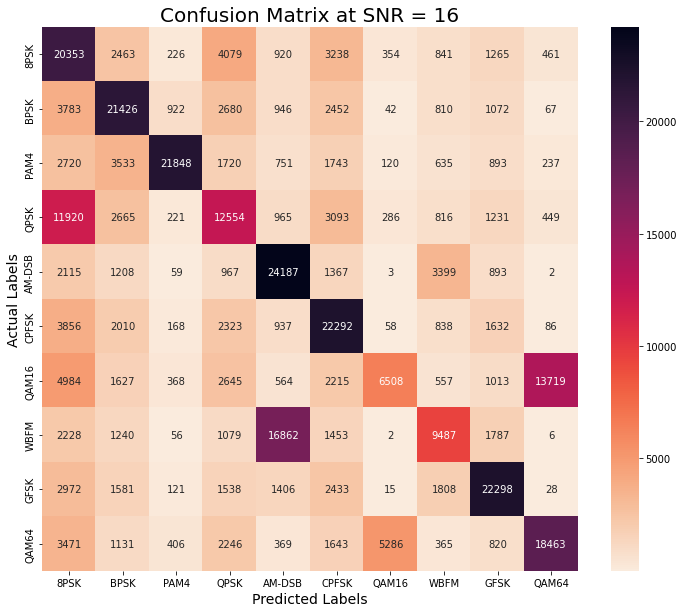

f1 score:  0.5167206490389524
test accuarcy: 0.524608187134503


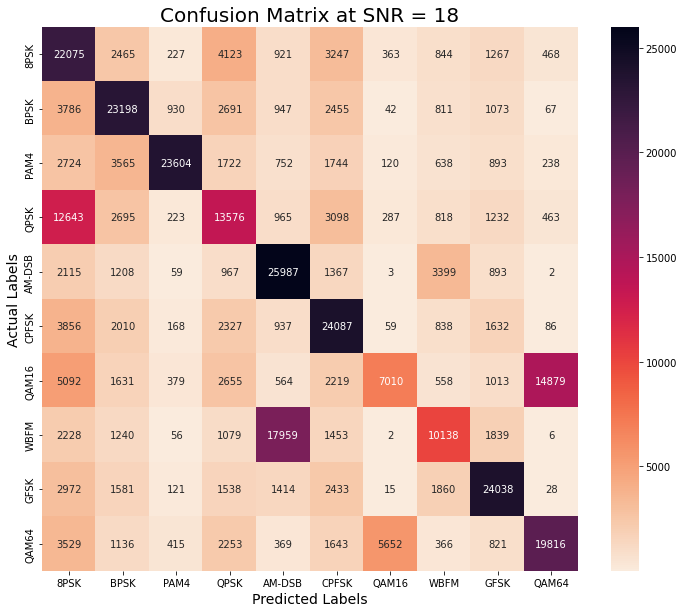

f1 score:  0.5288888081595499
test accuarcy: 0.5375805555555555


In [ ]:


snr_accuarcy=test_model(model)



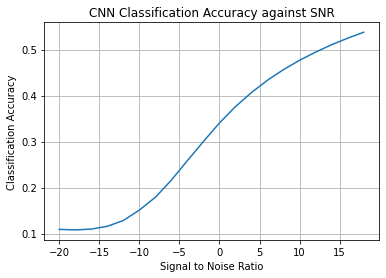

In [ ]:
# Plot accuracy curve
plt.plot(SNRs,snr_accuarcy);
plt.rcParams["figure.figsize"][0] = 15
plt.rcParams["figure.figsize"][1] = 5
plt.grid();
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN Classification Accuracy against SNR");